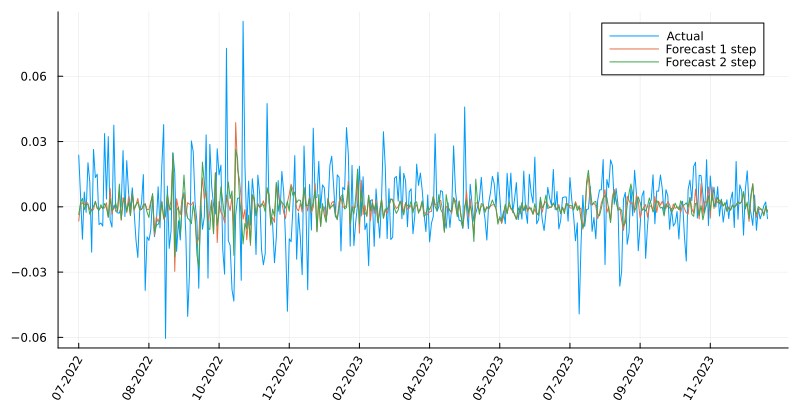

1:38:723
Any[0.00029517975735240574, 0.0002984869485492653]


In [1]:
using DataFrames, Random, Statistics, Plots
using AirBorne.ETL.YFinance: get_interday_data, get_chart_data, parse_intraday_raw_data
using RollingFunctions
using DirectSearch
using PrettyTables
using Suppressor
using Latexify
using Dates: DateTime, datetime2unix
using Dates

function regress(data, lookback=1, lookahead=1)
    num_samples = length(data) - lookback - lookahead + 1
    inputs = zeros(num_samples, lookback)
    outputs = zeros(num_samples, lookahead)
    for i  in 1:num_samples
        inputs[i,:] = (data[i:i+lookback-1]) 
        outputs[i,:] = data[i+lookback:i+lookback+lookahead-1]
    end
    params = inputs \ outputs 
    return params
end

function run_regression(data; lookback=1, lookahead=1, reparameterise_window=0, dates=Nothing)
    step_map = Dict()
    step_error = []
    load_idx = max(lookback, reparameterise_window, round(Int, length(data) / 2))
    loading_data = data[1:load_idx]
    running_data = data[load_idx+1:end]

    function run_func(x)
        all_data = [loading_data; x]
        if reparameterise_window != 0
            all_data = all_data[end-reparameterise_window+1:end]
        end
        multiplier = regress(all_data, lookback, lookahead)
        return all_data[end-lookback+1:end]' * multiplier
    end

    if reparameterise_window == 0
        reparameterise_window = length(running_data)
    end
    forecast = running(run_func, running_data, reparameterise_window)
    # println(forecast)
    for i in 1:lookahead
        if i == 1
            fill_data = []
        else
            fill_data = running_data[2:i]
        end
        fill_data = running_data[1:i]
        step_map[i] = [fill_data;collect(Iterators.flatten(f[i] for f in forecast))][1:length(running_data)]

        e = step_map[i][i+1:end] .- running_data[i+1:end]
        push!(step_error, mean((e).^2))
    end

    if dates != Nothing
        ticks = Dates.format.(dates, "dd-mm-yyyy")
        step_size = round(Int, length(running_data) / 10)
        tick_idx = 1:step_size:length(ticks)
        println(tick_idx)
        step_plot = plot(running_data[lookahead+1:end], xticks = (1:step_size:length(running_data),ticks[end-length(running_data)+1:step_size:end]), xrot=60, label="Actual", size=(800, 400))
    else
        step_plot = plot(running_data[lookahead+1:end], label="Actual", size=(800, 400))
    end
    for i in 1:lookahead
        plot!(step_map[i][lookahead+1:end], label="Forecast $i step")
    end
    return step_plot, step_error
end

unix(x) = string(round(Int, datetime2unix(DateTime(x))))
aapl = get_interday_data(["AAPL"], unix("2021-01-01"), unix("2024-01-01"))
returns = diff(log.(aapl.close))

p, error = run_regression(returns; lookback=5, lookahead=2, reparameterise_window=50, dates=aapl.date)
display(p)
println(error)


113
MADS Run Summary
------------------------------------------------
Feasible Solution           [1.0, 1.0, 45.0]
Feasible Cost               6.808711414937205e-6
Infeasible Solution         nothing
Infeasible Cost             nothing

Iterations                  58
Function Evaluations        32
Cache hits                  155
Optimization Status         Mesh Precision limit

Runtime                     1.2069320678710938
Search Time                 9.599999999999996e-6
Poll Time                   0.007785615999999997
Blackbox Evaluation Time    0.8991177029999999
1:6:565
Error with window = 3.393873401486781e-6
MADS Run Summary
------------------------------------------------
Feasible Solution           [5.0, 1.0, 0.0]
Feasible Cost               6.756655711880845e-6
Infeasible Solution         nothing
Infeasible Cost             nothing

Iterations                  50
Function Evaluations        6
Cache hits                  85
Optimization Status         Mesh Precision limit

Runt

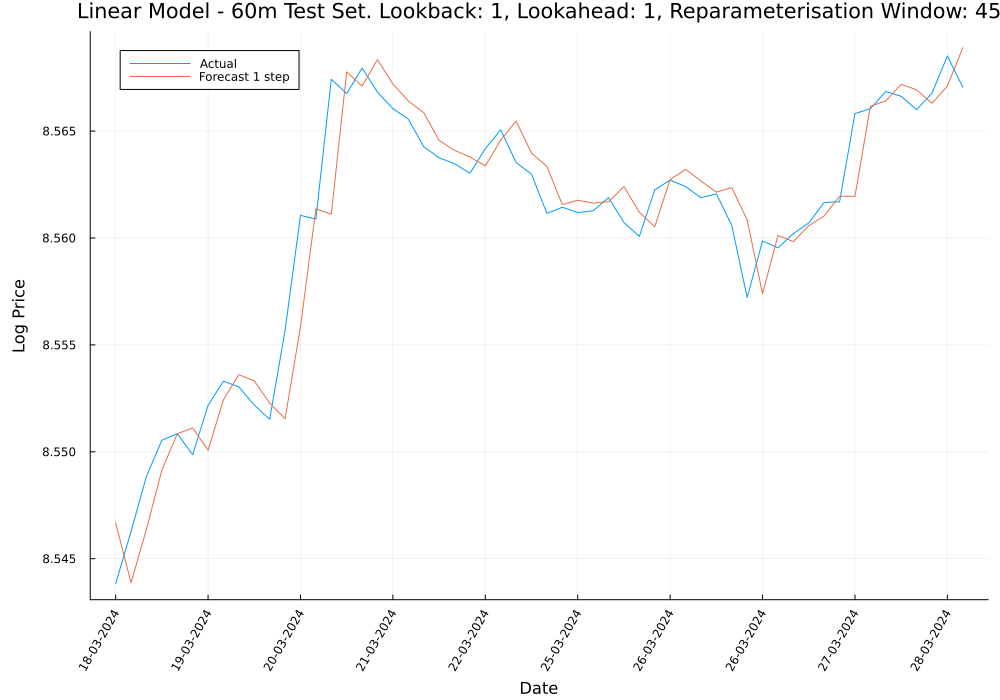

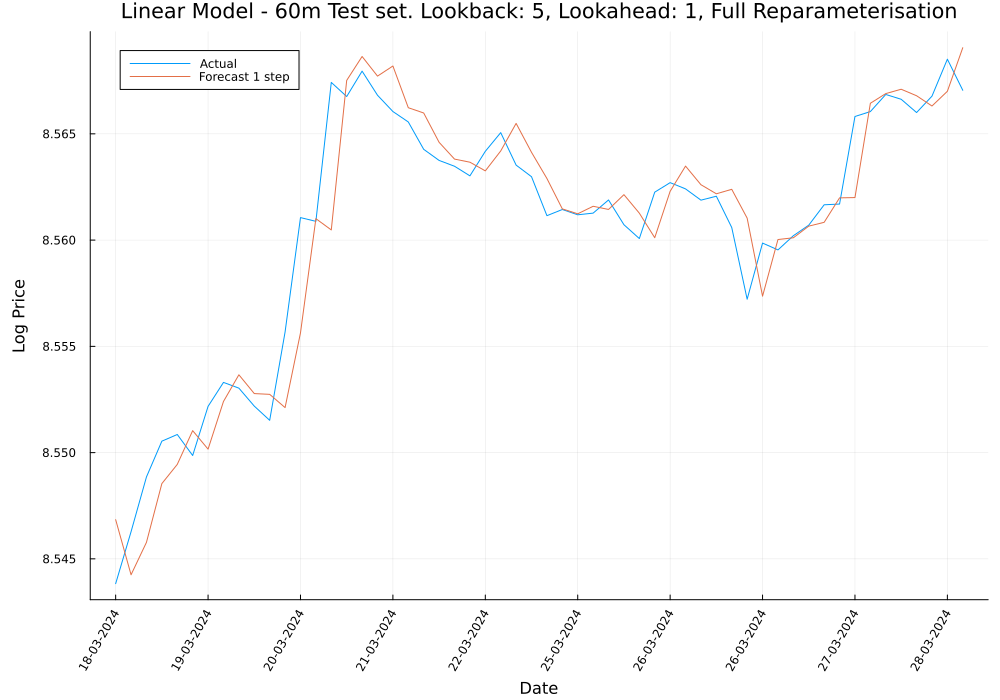

"/Users/sherifagbabiaka/Documents/uni-4/FYP/fyp_repo/linear_plots/linear_fixed_reparam/5_1_0_60m_TEST.svg"

In [8]:
using DirectSearch

unix(x) = string(round(Int, datetime2unix(DateTime(x))))
# sp500 = get_interday_data(["^GSPC"], unix("2021-01-01"), unix("2024-01-01"))
freq = "60m"

unix(x) = string(round(Int, datetime2unix(DateTime(x))))
sp500 = parse_intraday_raw_data(get_chart_data("^GSPC", unix("2023-12-01"), unix("2024-04-01"), freq))

price = log.(sp500.close)
train_idx = round(Int, length(price) * 0.8)
train, test = price[1:train_idx], price[train_idx+1:end]

function objective(x)
    params = round.(Int, x)
    obj_plot, errors = run_regression(train; lookback=params[1], lookahead=params[2], reparameterise_window=params[3])
    reparam_type = params[3] == 0 ? "Full Reparameterisation" : "Reparameterisation Window: $(params[3])"
    plot!(obj_plot; title="Linear Model - Train Set. Lookback: $(params[1]), Lookahead: $(params[2]), $(reparam_type)", size=(1000, 600))
    # savefig(obj_plot, "linear_plots/linear_fixed_reparam/$(params[1])_$(params[2])_$(params[3]).svg")
    return mean(errors)
end

# Optimising with a variable reparameterisation window
println(length(test))
problem = DSProblem(3, objective=objective, granularity=[1, 1, 1], initial_point=[5, 1, 50])
valcond(x) = (0 < x[1] < (length(test) / 2)) &&  (0 < x[2] <= 4) && (x[1] + x[2] < x[3] < round(Int, length(test) / 2))
AddExtremeConstraint(problem, valcond)
Optimize!(problem)

optimal = round.(Int, problem.x)

opt_plot, error_window = run_regression(test; lookback=optimal[1], lookahead=optimal[2], reparameterise_window=optimal[3], dates = sp500.date)

println("Error with window = $(mean(error_window))")
plot!(opt_plot; title="Linear Model - $(freq) Test Set. Lookback: $(optimal[1]), Lookahead: $(optimal[2]), Reparameterisation Window: $(optimal[3])", size=(1000, 700), ylabel="Log Price", xlabel="Date", left_margin=5Plots.mm, bottom_margin=5Plots.mm)
display(opt_plot)
savefig(opt_plot, "linear_plots/linear_reparam/$(optimal[1])_$(optimal[2])_$(optimal[3])_$(freq)_TEST.svg")

# Optimising with full reparameterisation window

problem = DSProblem(3, objective=objective, granularity=[1, 1, 1], initial_point=[5, 1, 0])
valcond(x) = (0 < x[1] < (length(test) / 2)) &&  (0 < x[2] <= 4) && (0 == x[3])
AddExtremeConstraint(problem, valcond)
Optimize!(problem)

optimal = round.(Int, problem.x)

opt_plot, error_no_window = run_regression(test; lookback=optimal[1], lookahead=optimal[2], reparameterise_window=optimal[3], dates = sp500.date)
println("Error with no window = $(mean(error_no_window))")
plot!(opt_plot; title="Linear Model - $(freq) Test set. Lookback: $(optimal[1]), Lookahead: $(optimal[2]), Full Reparameterisation", size=(1000, 700), ylabel="Log Price", xlabel="Date", left_margin=5Plots.mm, bottom_margin=5Plots.mm)
display(opt_plot)

savefig(opt_plot, "linear_plots/linear_fixed_reparam/$(optimal[1])_$(optimal[2])_$(optimal[3])_$(freq)_TEST.svg")


In [16]:
freq = "1d"

unix(x) = string(round(Int, datetime2unix(DateTime(x))))
sp500 = parse_intraday_raw_data(get_chart_data("^GSPC", unix("2021-01-01"), unix("2024-01-01"), freq))

price = log.(sp500.close)
train_idx = round(Int, length(price) * 0.8)
train, test = price[1:train_idx], price[train_idx+1:end]

opt_plot, error_window = run_regression(test; lookback=1, lookahead=1, reparameterise_window=45, dates = sp500.date)
println("Error with no window = $(mean(error_window))")

1:8:753
Error with no window = 6.315506033030393e-5


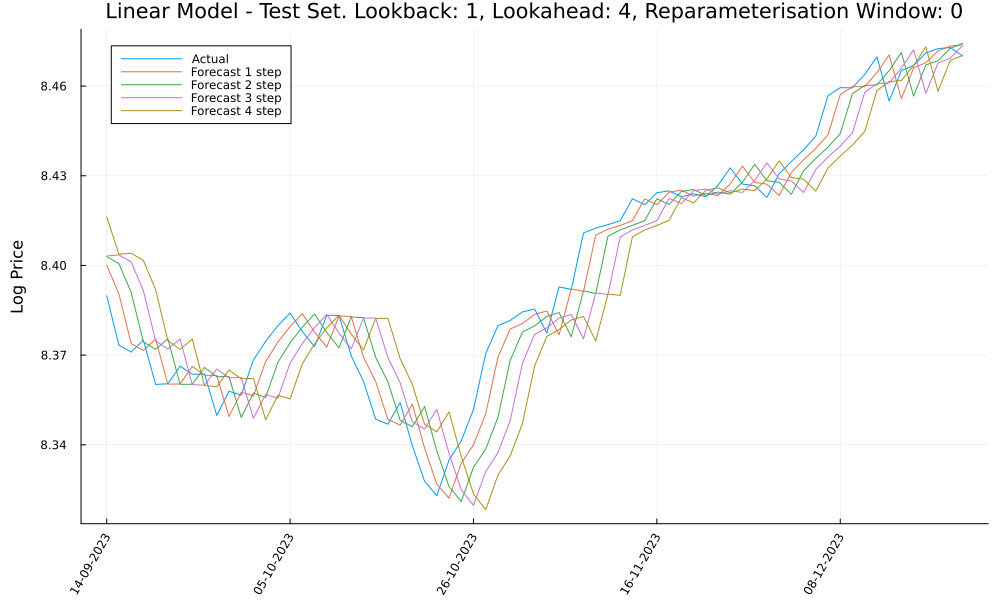

MADS Run Summary
--------------------------------------------------
Feasible Solution           [1.0, 4.0, 0.0]
Feasible Cost               0.00046443688627248854
Infeasible Solution         nothing
Infeasible Cost             nothing

Iterations                  56
Function Evaluations        6
Cache hits                  25
Optimization Status         Mesh Precision limit

Runtime                     0.86472487449646
Search Time                 7.539999999999996e-6
Poll Time                   0.006417769000000001
Blackbox Evaluation Time    0.23151748900000002
1:15:751
Error with window = 0.00022072815063005235


In [106]:
function objective(x)
    params = round.(Int, x)
    obj_plot, errors = run_regression(train; lookback=params[1], lookahead=params[2], reparameterise_window=params[3])
    plot!(obj_plot; title="Linear Model - Train Set. Lookback: $(params[1]), Lookahead: $(params[2]), Full Reparameterisation", size=(1000, 600))
    # savefig(obj_plot, "linear_plots/linear_fixed_reparam/$(params[1])_$(params[2])_$(params[3]).svg")
    return mean(errors)
end

# Optimising with a variable reparameterisation window
problem = DSProblem(3, objective=objective, granularity=[1, 1, 1], initial_point=[5, 4, 0])
valcond(x) = (0 < x[1] < (length(test) / 2)) &&  (x[2] == 4) && (x[3] == 0)
AddExtremeConstraint(problem, valcond)
Optimize!(problem)

optimal = round.(Int, problem.x)

opt_plot, error_window = run_regression(test; lookback=optimal[1], lookahead=optimal[2], reparameterise_window=optimal[3], dates = sp500.date)

println("Error with window = $(mean(error_window))")
plot!(opt_plot; title="Linear Model - Test Set. Lookback: $(optimal[1]), Lookahead: $(optimal[2]), Reparameterisation Window: $(optimal[3])", size=(1000, 600), ylabel="Log Price", left_margin=5Plots.mm, bottom_margin=5Plots.mm)
display(opt_plot)
# savefig(opt_plot, "linear_plots/linear_reparam/$(optimal[1])_$(optimal[2])_$(optimal[3])_TEST.svg")

# Using S and P 500

In [39]:
using DirectSearch

unix(x) = string(round(Int, datetime2unix(DateTime(x))))
aapl = get_interday_data(["^GSPC"], unix("2021-01-01"), unix("2024-01-01"))
returns = log.(aapl.close)
train_idx = round(Int, length(returns) * 0.8)
train, test = returns[1:train_idx], returns[train_idx+1:end]

function objective(x)
    params = round.(Int, x)
    obj_plot, errors = run_regression(train; lookback=params[1], lookahead=params[2], reparameterise_window=params[3])
    plot!(obj_plot; title="Linear Model - Train Set. Lookback: $(params[1]), Lookahead: $(params[2]), Full Reparameterisation", size=(1000, 600))
    # savefig(obj_plot, "linear_plots/linear_fixed_reparam/$(params[1])_$(params[2])_$(params[3]).svg")
    return mean(errors)
end

function obj2(x; data=train)
    params = round.(Int, x)
    T = length(data)
    if params[3] == 0
        t0 = round(Int, T/2)
        window = t0
    else
        t0 = params[3]+1
        window = params[3]
    end
    t0 = params[3] == 0 ? round(Int, T/2) : params[3]+1
    function g(P, F, W, t)
        return data[t-P+1:t]' * regress(data[t-W+1:t], P, F)
    end
    loss = (1/params[2]) * sum((1/(T-t0+1)) * sum((g(params[1], params[2], window, t)[i] - data[t+i])^2 for t in t0:T-i) for i in 1:params[2])
    return loss
end

println(obj2([5, 1, 50]))
println(objective([5, 1, 50]))

# # Optimising with a variable reparameterisation window

# problem = DSProblem(3, objective=objective, granularity=[1, 1, 1], initial_point=[5, 1, 50])
# valcond(x) = (0 < x[1] < (length(test) / 2)) &&  (0 < x[2] <= 4) && (0 < x[3] < round(Int, length(test) / 2))
# AddExtremeConstraint(problem, valcond)
# Optimize!(problem)

# optimal = round.(Int, problem.x)

# opt_plot, error_window = run_regression(test; lookback=optimal[1], lookahead=optimal[2], reparameterise_window=optimal[3])
# println("Error with window = $(mean(error_window))")
# plot!(opt_plot; title="Linear Model - Test Set. Lookback: $(optimal[1]), Lookahead: $(optimal[2]), Reparameterisation Window: $(optimal[3])", size=(1000, 600))
# display(opt_plot)
# # savefig(opt_plot, "linear_plots/linear_reparam/$(optimal[1])_$(optimal[2])_$(optimal[3])_TEST.svg")

# # Optimising with full reparameterisation window

# problem = DSProblem(3, objective=objective, granularity=[1, 1, 1], initial_point=[5, 1, 0])
# valcond(x) = (0 < x[1] < (length(test) / 2)) &&  (0 < x[2] <= 4) && (0 == x[3])
# AddExtremeConstraint(problem, valcond)
# Optimize!(problem)

# optimal = round.(Int, problem.x)

# opt_plot, error_no_window = run_regression(test; lookback=optimal[1], lookahead=optimal[2], reparameterise_window=optimal[3])
# println("Error with no window = $(mean(error_no_window))")
# plot!(opt_plot; title="Linear Model - Test Set. Lookback: $(optimal[1]), Lookahead: $(optimal[2]), Full Reparameterisation", size=(1000, 600))
# display(opt_plot)

# savefig(opt_plot, "linear_plots/linear_fixed_reparam/$(optimal[1])_$(optimal[2])_$(optimal[3])_TEST.svg")

0.0001673371244993847
0.00022895234459486462


# Using 5 minute intervals

[170.74000549316406, 170.66000366210938, 170.36000061035156, 170.28990173339844, 170.11000061035156, 170.13499450683594, 170.0850067138672, 170.17970275878906, 170.04010009765625, 169.86500549316406, 170.1396942138672, 170.08990478515625, 170.05999755859375, 169.85499572753906, 170.02499389648438, 169.97999572753906, 169.9199981689453, 169.8800048828125, 169.73500061035156, 169.6230926513672, 169.60499572753906, 169.60470581054688, 169.74000549316406, 169.84500122070312, 169.8800048828125, 169.97000122070312, 169.97300720214844, 170.03309631347656, 169.67999267578125, 169.64010620117188, 169.89979553222656, 169.97999572753906, 169.9499969482422, 169.86500549316406, 169.8404998779297, 169.89500427246094, 169.90499877929688, 169.91580200195312, 169.875, 169.8249969482422, 169.83999633789062, 169.8350067138672, 169.91900634765625, 169.85000610351562, 169.89500427246094, 169.97500610351562, 169.7949981689453, 169.9156951904297, 169.9250030517578, 169.98500061035156, 170.05499267578125, 170

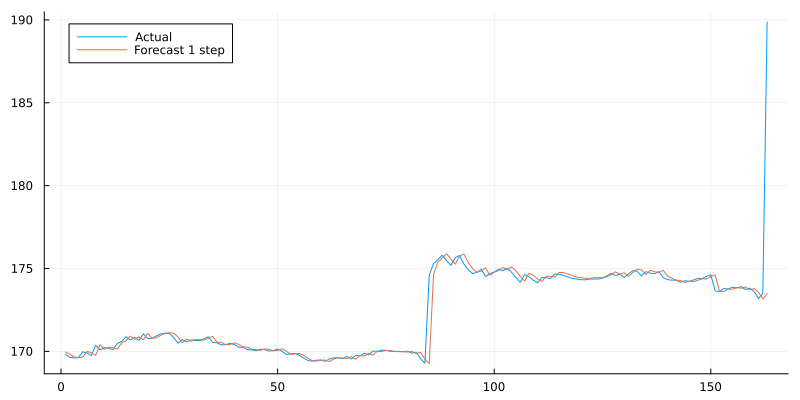

In [40]:
using AirBorne.ETL.YFinance: get_chart_data, parse_intraday_raw_data

unix(x) = string(round(Int, datetime2unix(DateTime(x))))
aapl = parse_intraday_raw_data(get_chart_data("AAPL", unix("2024-04-01"), unix("2024-04-30"), "5m"))

returns = aapl.close
println(returns)

train_idx = round(Int, length(returns) * 0.8)
train, test = returns[1:train_idx], returns[train_idx+1:end]

function objective(x)
    params = round.(Int, x)
    _, errors = run_regression(train; lookback=params[1], lookahead=params[2], reparameterise_window=params[3])
    # println("params: $(params), error: $(mean(errors))")
    return mean(errors)
end

problem = DSProblem(3, objective=objective, granularity=[1, 1, 1], initial_point=[5, 4, 50])
valcond(x) = (0 < x[1] < (length(test) / 2)) &&  (0 < x[2] <= 4) && (0 < x[3] < round(Int, length(test) / 2))
AddExtremeConstraint(problem, valcond)
Optimize!(problem)

optimal = round.(Int, problem.x)

opt_plot, error_window = run_regression(test; lookback=optimal[1], lookahead=optimal[2], reparameterise_window=optimal[3])
println("Error with window = $(mean(error_window))")
display(opt_plot)


# Known System 

In [60]:
sk = [0.0, 1.0]
for i in 2:20
    push!(sk, sk[i-1] + sk[i])
end
ik = [1.0, 1.0, 1.0, 1.0]
for i in 5:20
    push!(ik, ik[i-1] + ik[i-2] - ik[i-3] - ik[i-4])
end

lk = []
for i in 1:20
    push!(lk, i + sin(i) + cos(i))
end


function objective(x; data=sk, folder="fibb", title="S_k")
    params = round.(Int, x)
    plt, errors = run_regression(data; lookback=params[1], lookahead=params[2], reparameterise_window=params[3])
    plot!(plt; title="Linear Model - $(title). Lookback: $(params[1]), Lookahead: $(params[2]), Full Reparameterisation", size=(1000, 600))
    # println("params: $(params), error: $(mean(errors))")
    savefig(plt, "linear_plots/$(folder)/$(params[1])_$(params[2])_$(params[3]).svg")
    return mean(errors)
end
paramset_s = [[1,1,0],[1,2,0], [2,1,0], [2,2,0], [3,1,0], [3,2,0], [3,3,0], [1,3,0], [2,3,0]]
println("sk")
for p in paramset_s
    println(p, objective(p; data=sk))
end
paramset_i = [[4,1,0], [3,1,0], [2,3,0], [1,2,0], [1,3,0], [4,3,0]]
println("ik")
for p in paramset_i
    println(p, objective(p; data=ik, folder="ik", title = "I_k"))
end
paramset_l = [[4,1,0], [3,1,0], [2,2,0], [1,2,0], [1,3,0], [2,3,0], [4,2,0], [4,3,0]]
println("uk")
for p in paramset_l
    println(p, objective(p; data=lk, folder="uk", title = "U_k"))
end
# println(lk)

sk
[1, 1, 0]8.885705609389253e-5
[1, 2, 0]0.00019519313787744636
[2, 1, 0]2.5469731165817347e-25
[2, 2, 0]3.8059642680879542e-25
[3, 1, 0]4.258687684940979e-25
[3, 2, 0]2.717103417264706e-25
[3, 3, 0]4.743244151987739e-26
[1, 3, 0]0.00584612308416789
[2, 3, 0]1.695738206701861e-25
ik
[4, 1, 0]3.649796454822548e-28
[3, 1, 0]0.005397615045261226
[2, 3, 0]1.1386288508083613
[1, 2, 0]1572.950183724849
[1, 3, 0]2845.348622065092
[4, 3, 0]5.833396831412095e-29
uk
[4, 1, 0]4.585911395684816e-28
[3, 1, 0]0.23313302685420695
[2, 2, 0]3.3918915631215536
[1, 2, 0]3.7279189755573876
[1, 3, 0]5.713489279337378
[2, 3, 0]5.76581430796442
[4, 2, 0]5.270467358993271e-27
[4, 3, 0]1.0353897049518808e-25
